In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet
from scarlet.display import AsinhMapping
from scarlet.source import StarletSource

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import sep

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row
from astropy.convolution import convolve, Gaussian2DKernel


Bad key savefig.frameon in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [4]:
lsbg_cat = Table.read('./Cutout/NSA/nsa_20hosts_cutout_cat.fits')
#('./Cutout/NSA/nsa_cutout_cat_1013.fits')

In [29]:
length = len(lsbg_cat)
bands = 4

meas_cat = Table([
    Column(name='ID', length=length, dtype=int),
    Column(name='flux', length=length, shape=(bands,)),
    Column(name='mag', length=length, shape=(bands,)),
    Column(name='SB_0', length=length, shape=(bands,)),
    Column(name='SB_eff_circ', length=length, shape=(bands,)),
    Column(name='SB_eff_ellip', length=length, shape=(bands,)),
    Column(name='xc_cen', length=length),
    Column(name='yc_cen', length=length),
    Column(name='xc_sym', length=length),
    Column(name='yc_sym', length=length),
    Column(name='ell_cen', length=length),
    Column(name='ell_sym', length=length),
    Column(name='PA_cen', length=length),
    Column(name='PA_sym', length=length),
    Column(name='rhalf_circ', length=length),
    Column(name='rhalf_ellip', length=length),
    Column(name='r20', length=length),
    Column(name='r50', length=length),
    Column(name='r80', length=length),
    Column(name='Gini', length=length),
    Column(name='M20', length=length),
    Column(name='F(G,M20)', length=length),
    Column(name='S(G,M20)', length=length),
    Column(name='C', length=length),
    Column(name='A', length=length),
    Column(name='A_outer', length=length),
    Column(name='A_shape', length=length),
    Column(name='S', length=length),
    Column(name='sersic_n', length=length),
    Column(name='sersic_rhalf', length=length),
    Column(name='sersic_ell', length=length),
    Column(name='sersic_PA', length=length),
    Column(name='sersic_xc', length=length),
    Column(name='sersic_yc', length=length),
    Column(name='sersic_amp', length=length),
    Column(name='flag', length=length, dtype=bool),
    Column(name='flag_sersic', length=length, dtype=bool),
])
for col in meas_cat.columns:
    meas_cat[col] = np.nan * meas_cat[col]

In [30]:
from kuaizi.measure import _write_to_row, measure_image_tigress

In [31]:
from IPython.display import clear_output

In [32]:
for i, lsbg in enumerate(lsbg_cat):
    clear_output(wait=True)
    
    row = meas_cat[i]
    row['ID'] = lsbg['viz-id']
    
    # Measure!
    try:
        measurement = measure_image_tigress(
            {'project': 'HSC', 
             'name': 'LSBG', 
             'data_dir': '/scratch/gpfs/jiaxuanl/Data'}, 
            lsbg, show_figure_statmorph=False, figure_dir='./Figure/statmorph/')
        row = _write_to_row(row, measurement)
#         with open(f"./Measure/NSA/nsa-{lsbg['viz-id']}-wavelet.df", "wb") as fp:
#             dill.dump([measurement, morph], fp)
#             fp.close()
    except Exception as e:
        print(i, e)
        
    if i % 5 == 0:
        print(f'Progress: {i}')

    Working directory: /scratch/gpfs/jiaxuanl/Data/HSC/LSBG
  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    6 stars from Gaia are masked!
    Detected 246 objects
    6 stars from Gaia are masked!
    Detected 203 objects
    Detected 83 objects
Progress: 500


In [33]:
meas_cat.write('./Catalog/nsa_sample_images_measurement_1119_success.fits', overwrite=True)

### Analysis

In [5]:
import kuaizi
import pickle
from astropy.cosmology import Planck15
cosmos = Planck15
h = cosmos.h
kuaizi.set_matplotlib(style='nature', usetex=False)

In [6]:
meas_cat = Table.read('./Catalog/nsa_vanilla_sample_measurement_1103_success.fits')
meas_cat_img = Table.read('./Catalog/nsa_sample_images_measurement_1119_success.fits')

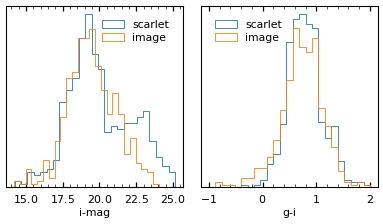

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(axes[0])
plt.hist(meas_cat['mag'][:, 2], 
         label='scarlet', histtype='step', bins=25)
plt.hist(meas_cat_img['mag'][:, 2], 
         label='image', histtype='step', bins=25)
plt.legend()
plt.xlabel('i-mag')
plt.yticks([]);

plt.sca(axes[1])
plt.hist(meas_cat['mag'][:, 0] - meas_cat['mag'][:, 2], 
         label='scarlet', histtype='step', range=(-1, 2), bins=25)
plt.hist(meas_cat_img['mag'][:, 0] - meas_cat_img['mag'][:, 2], 
         label='image', histtype='step', range=(-1, 2), bins=25)
plt.legend(loc='upper left')
plt.xlabel('g-i')
plt.yticks([]);

In [8]:
meas_cat['C'] = meas_cat_img['C']
meas_cat['A'] = meas_cat_img['A']
meas_cat['A_outer'] = meas_cat_img['A_outer']
meas_cat['S'] = meas_cat_img['S']
meas_cat['Gini'] = meas_cat_img['Gini']
meas_cat['M20'] = meas_cat_img['M20']
meas_cat['F(G,M20)'] = meas_cat_img['F(G,M20)']
meas_cat['S(G,M20)'] = meas_cat_img['S(G,M20)']

In [9]:
meas_cat['rhalf_circ_phys'] = (lsbg_cat['host_ang_diam_dist'] * meas_cat['rhalf_circ'] * 0.168 / 206265).to(u.kpc)
meas_cat['rhalf_ellip_phys'] = (lsbg_cat['host_ang_diam_dist'] * meas_cat['rhalf_ellip'] * 0.168 / 206265).to(u.kpc)
meas_cat['r20_phys'] = (lsbg_cat['host_ang_diam_dist'] * meas_cat['r20'] * 0.168 / 206265).to(u.kpc)

# stellar mass estimation
meas_cat['abs_mag'] = meas_cat['mag'] - 25 - 5 * np.log10(lsbg_cat['host_ang_diam_dist'])[:, np.newaxis] # ugri
BV = 0.62 * (meas_cat['mag'][:, 0] - meas_cat['mag'][:, 1]) + 0.15
V = meas_cat['mag'][:, 0] - 0.52 * (meas_cat['mag'][:, 0] - meas_cat['mag'][:, 1]) - 0.03
V_abs = V - 25 - 5 * np.log10(lsbg_cat['host_ang_diam_dist'])
log_ML_V = 1.493 * BV - 0.681
M = (4.83 - V_abs) / (2.5) + log_ML_V
meas_cat['log_m_star'] = M

In [10]:
jg_votes = Table.read('./Catalog/20hosts/LSBG_Zoo_jgreene_2021_11_17_20_48_40.log', format='ascii')
jg_votes.rename_columns(jg_votes.colnames, ['name', 'gal', 'candy', 'junk'])
jg_votes['viz-id'] = [int(item.lstrip('nsa_')) for item in jg_votes['name']]
jg_votes.remove_column('name')
for key in ['gal', 'candy', 'junk']:
    jg_votes[key] = jg_votes[key].data.astype(bool)
    
jg_votes.sort('viz-id')

In [11]:
jl_votes = Table.read('./Catalog/20hosts/LSBG_Zoo_jiaxuanl_2021_11_17_00_27_18.log', format='ascii')
jl_votes.rename_columns(jl_votes.colnames, ['name', 'gal', 'candy', 'junk'])
jl_votes['viz-id'] = [int(item.lstrip('nsa_')) for item in jl_votes['name']]
jl_votes.remove_column('name')
for key in ['gal', 'candy', 'junk']:
    jl_votes[key] = jl_votes[key].data.astype(bool)
    
jl_votes.sort('viz-id')

In [19]:
if np.sum(meas_cat['ID'] != jl_votes['viz-id']) == 0:
    for key in ['gal', 'candy', 'junk']:
        meas_cat[key] = jl_votes[key]
        
junk = meas_cat['junk']
candy = meas_cat['candy']
gal = meas_cat['gal']

In [20]:
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

In [21]:
print('Candy:', np.sum(candy))
print('Gal:', np.sum(gal))
print('Junk:', np.sum(junk))

Candy: 88
Gal: 271
Junk: 142


(-0.5, 2.2)

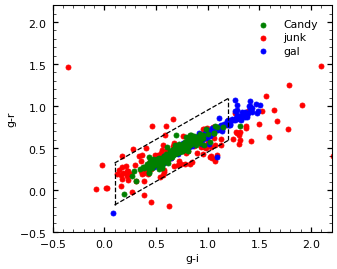

In [15]:
plt.scatter((g_mag - i_mag)[candy], (g_mag - r_mag)[candy], color='g', zorder=10, label='Candy')
plt.scatter((g_mag - i_mag)[junk], (g_mag - r_mag)[junk], color='r', label='junk')
plt.scatter((g_mag - i_mag)[gal], (g_mag - r_mag)[gal], color='b', label='gal')

color_bound = [0.1, 1.2]
half_width = 0.25
plt.vlines(color_bound[0], 0.7 * color_bound[0] - half_width, 
           0.7 * color_bound[0] + half_width, color='k', ls='--')
plt.vlines(color_bound[1], 0.7 * color_bound[1] - half_width, 
           0.7 * color_bound[1] + half_width, color='k', ls='--')

x = np.linspace(color_bound[0], color_bound[1], 100)
plt.plot(x, 0.7 * x - half_width, color='k', ls='--')
plt.plot(x, 0.7 * x + half_width, color='k', ls='--')

plt.xlabel('g-i')
plt.ylabel('g-r')

plt.legend()

plt.xlim(-0.5, 2.2)
plt.ylim(-0.5, 2.2)

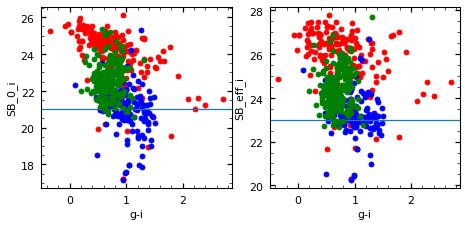

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

plt.sca(axes[0])
plt.scatter((g_mag - i_mag)[candy], meas_cat['SB_0'][:, 2][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['SB_0'][:, 2][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['SB_0'][:, 2][gal], color='b')
plt.xlabel('g-i')
plt.ylabel('SB_0_i')
plt.axhline(21.)

plt.sca(axes[1])
plt.scatter((g_mag - i_mag)[candy], meas_cat['SB_eff_ellip'][:, 1][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['SB_eff_ellip'][:, 1][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['SB_eff_ellip'][:, 1][gal], color='b')
plt.xlabel('g-i')
plt.ylabel('SB_eff_i')
plt.axhline(23.)

plt.subplots_adjust(wspace=0.2)

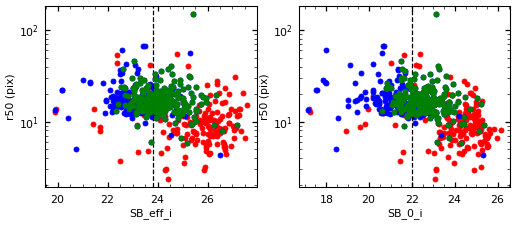

In [93]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(ax1)
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][candy ], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][junk ], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][~junk ], meas_cat['rhalf_ellip'][~junk], color='b')

plt.axvline(23.8, color='k', ls='--')
plt.yscale('log')
plt.xlabel('SB_eff_i')
plt.ylabel('r50 (pix)')

plt.sca(ax2)
plt.scatter(meas_cat['SB_0'][:, 2][candy ], meas_cat['rhalf_ellip'][candy ], color='g', zorder=10)
plt.scatter(meas_cat['SB_0'][:, 2][junk ], meas_cat['rhalf_ellip'][junk ], color='r')
plt.scatter(meas_cat['SB_0'][:, 2][~junk ], meas_cat['rhalf_ellip'][~junk ], color='b')

plt.axvline(22., color='k', ls='--')
plt.yscale('log')
plt.xlabel('SB_0_i')
plt.ylabel('r50 (pix)')

plt.subplots_adjust(wspace=0.2)

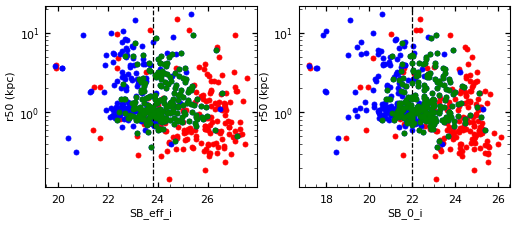

In [94]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(ax1)
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][candy ], meas_cat['rhalf_ellip_phys'][candy], color='g', zorder=10)
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][junk ], meas_cat['rhalf_ellip_phys'][junk], color='r')
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][~junk ], meas_cat['rhalf_ellip_phys'][~junk], color='b')

plt.axvline(23.8, color='k', ls='--')
plt.yscale('log')
plt.xlabel('SB_eff_i')
plt.ylabel('r50 (kpc)')

plt.sca(ax2)
plt.scatter(meas_cat['SB_0'][:, 2][candy ], meas_cat['rhalf_ellip_phys'][candy ], color='g', zorder=10)
plt.scatter(meas_cat['SB_0'][:, 2][junk ], meas_cat['rhalf_ellip_phys'][junk ], color='r')
plt.scatter(meas_cat['SB_0'][:, 2][~junk ], meas_cat['rhalf_ellip_phys'][~junk ], color='b')

plt.axvline(22., color='k', ls='--')
plt.yscale('log')
plt.xlabel('SB_0_i')
plt.ylabel('r50 (kpc)')

plt.subplots_adjust(wspace=0.2)

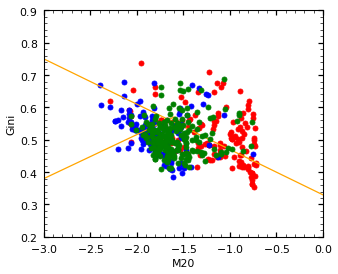

In [95]:
plt.scatter(meas_cat['M20'][candy], meas_cat['Gini'][candy], color='g', zorder=10)
plt.scatter(meas_cat['M20'][junk], meas_cat['Gini'][junk], color='r')
plt.scatter(meas_cat['M20'][gal], meas_cat['Gini'][gal], color='b')

plt.xlabel('M20')
plt.ylabel('Gini')

plt.xlim(-3, 0)
plt.ylim(0.2, 0.9)

x = np.linspace(-3, 0, 10)
plt.plot(x, -0.14 * x + 0.33, color='orange')
x = np.linspace(-3, -1.6, 10)
plt.plot(x, 0.136 * x + 0.788, color='orange')

Text(0, 0.5, 'A')

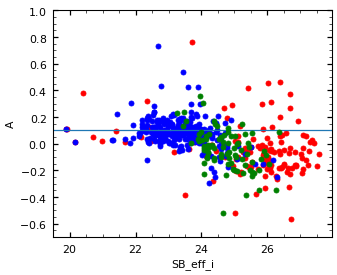

In [22]:
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][candy], meas_cat['A'][candy], color='g', zorder=10)
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][junk], meas_cat['A'][junk], color='r')
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][gal], meas_cat['A'][gal], color='b')
plt.ylim(-.7, 1)
#plt.axvline(3.3)
plt.axhline(0.1)
plt.xlabel('SB_eff_i')
plt.ylabel('A')

Text(0, 0.5, 'A_max')

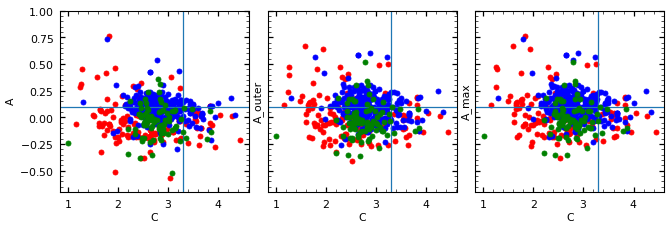

In [171]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)

plt.sca(axes[0])
plt.scatter(meas_cat['C'][candy], meas_cat['A'][candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], meas_cat['A'][junk], color='r')
plt.scatter(meas_cat['C'][gal], meas_cat['A'][gal], color='b')
plt.ylim(-.7, 1)
plt.axvline(3.3)
plt.axhline(0.1)
plt.xlabel('C')
plt.ylabel('A')

plt.sca(axes[1])
plt.scatter(meas_cat['C'][candy], meas_cat['A_outer'][candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], meas_cat['A_outer'][junk], color='r')
plt.scatter(meas_cat['C'][gal], meas_cat['A_outer'][gal], color='b')
plt.ylim(-.7, 1)
plt.axvline(3.3)
plt.axhline(0.1)
plt.xlabel('C')
plt.ylabel('A_outer')

plt.sca(axes[2])
A_max = np.max([meas_cat['A_outer'], meas_cat['A']], axis=0)
plt.scatter(meas_cat['C'][candy], A_max[candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], A_max[junk], color='r')
plt.scatter(meas_cat['C'][gal], A_max[gal], color='b')
plt.ylim(-.7, 1)
plt.axvline(3.3)
plt.axhline(0.1)
plt.xlabel('C')
plt.ylabel('A_max')

Text(0, 0.5, 'S')

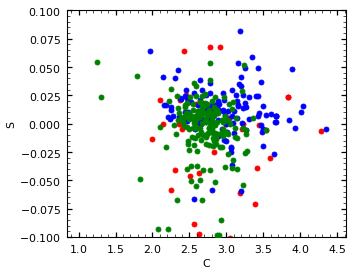

In [102]:
plt.scatter(meas_cat['C'][candy], meas_cat['S'][candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], meas_cat['S'][junk], color='r')
plt.scatter(meas_cat['C'][gal], meas_cat['S'][gal], color='b')

plt.ylim(-0.1, 0.1)
plt.xlabel('C')
plt.ylabel('S')

Text(0, 0.5, 'r50')

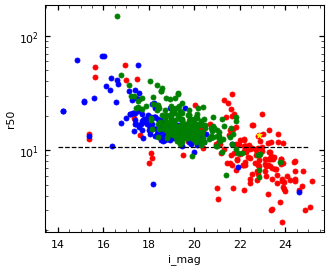

In [107]:
plt.scatter(i_mag[candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter(i_mag[junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter(i_mag[gal], meas_cat['rhalf_ellip'][gal], color='b')
plt.scatter(i_mag[223], meas_cat['rhalf_ellip'][223], color='yellow', marker='*', s=50, label='gal', zorder=10)


#plt.ylim(0, 1)
plt.hlines(1.8 / 0.168, 14, 25, color='k', ls='--')
plt.yscale('log')
plt.xlabel('i_mag')
plt.ylabel('r50')

(0.0, 30.0)

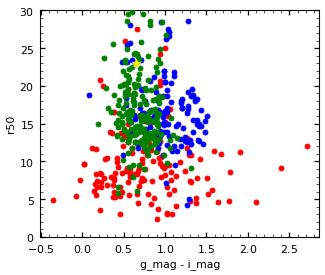

In [199]:
plt.scatter((g_mag - i_mag)[candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['rhalf_ellip'][gal], color='b')
plt.scatter((g_mag - i_mag)[327], meas_cat['rhalf_ellip'][327], color='yellow', marker='*', s=100, label='gal', zorder=10)

#plt.ylim(0, 1)
#plt.yscale('log')
plt.xlabel('g_mag - i_mag')
plt.ylabel('r50')

plt.ylim(0, 30)

In [242]:
print('Candy:', np.sum(candy))
print('Gal:', np.sum(gal))
print('Junk:', np.sum(junk))

Candy: 208
Gal: 138
Junk: 155


In [189]:
# Cuts based on JG votes
color_bound = [0.1, 1.2]
half_width = 0.25

mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)
mask &= (meas_cat['rhalf_ellip'] > 1.8 / 0.168)
#mask &= (meas_cat['SB_0'][:, 2] > 21)
mask &= (meas_cat['SB_eff_ellip'][:, 2] > 23.)

mask &= (meas_cat['M20'] < -1.1)
mask &= (meas_cat['Gini'] < 0.7)
mask &= ~((meas_cat['M20'] < -1.6) & (
    meas_cat['Gini'] > meas_cat['M20'] * 0.136 + 0.788) & (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.33))

mask &= (meas_cat['C'] < 3.5)
mask &= (meas_cat['A_outer'] >= 0.13)


print('Candy:', np.sum(mask & candy))
print('Gal:', np.sum(mask & gal))
print('Junk:', np.sum(mask & junk))

Candy: 47
Gal: 10
Junk: 2


In [169]:
if np.sum(meas_cat['ID'] != jl_votes['viz-id']) == 0:
    for key in ['gal', 'candy', 'junk']:
        meas_cat[key] = jl_votes[key]
        
junk = meas_cat['junk']
candy = meas_cat['candy']
gal = meas_cat['gal']

Text(0, 0.5, 'A_max')

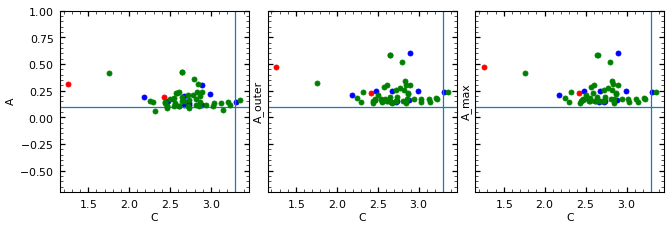

In [190]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)

plt.sca(axes[0])
plt.scatter(meas_cat['C'][candy & mask], meas_cat['A'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk & mask], meas_cat['A'][junk & mask], color='r')
plt.scatter(meas_cat['C'][gal & mask], meas_cat['A'][gal & mask], color='b')
plt.ylim(-.7, 1)
plt.axvline(3.3)
plt.axhline(0.1)
plt.xlabel('C')
plt.ylabel('A')

plt.sca(axes[1])
plt.scatter(meas_cat['C'][candy & mask], meas_cat['A_outer'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk & mask], meas_cat['A_outer'][junk & mask], color='r')
plt.scatter(meas_cat['C'][gal & mask], meas_cat['A_outer'][gal & mask], color='b')
plt.ylim(-.7, 1)
plt.axvline(3.3)
plt.axhline(0.1)
plt.xlabel('C')
plt.ylabel('A_outer')

plt.sca(axes[2])
A_max = np.max([meas_cat['A_outer'], meas_cat['A']], axis=0)
plt.scatter(meas_cat['C'][candy & mask], A_max[candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk & mask], A_max[junk & mask], color='r')
plt.scatter(meas_cat['C'][gal & mask], A_max[gal & mask], color='b')
plt.ylim(-.7, 1)
plt.axvline(3.3)
plt.axhline(0.1)
plt.xlabel('C')
plt.ylabel('A_max')

In [195]:
meas_cat_img[meas_cat_img['ID'] == 34010][['A', 'A_outer']]

A,A_outer
float64,float64
0.004310356716156072,-0.031983824795207026


In [178]:
meas_cat[mask].write('./Catalog/20hosts/after_size_color_sb_cas_cut_jg_large_A.fits', overwrite=True)

In [146]:
udg_flag = (meas_cat['rhalf_ellip_phys'] > 1.5) & (meas_cat['SB_0'][:, 0] > 24)

In [147]:
np.sum(udg_flag & mask)

18

In [148]:
np.sum(udg_flag & mask & junk)

3

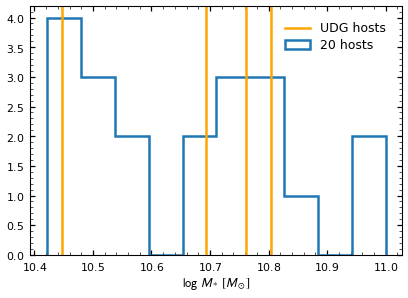

In [300]:
fig, ax = plt.subplots(figsize=(8, 5.5))
plt.hist(host_cat['log_m_star'], histtype='step', lw=3, label='20 hosts')

plt.xlabel(r'$\log\ M_*\ [M_\odot]$', fontsize=15)

for i, mass in enumerate(meas_cat[(udg_flag & mask)]['host_log_m_star']):
    label = 'UDG hosts' if i == 0 else None
    plt.axvline(mass, color='orange', lw=3, label=label)
    
plt.legend(fontsize=15)

In [152]:
spiral_flag = lsbg_cat['host_spiral'][(udg_flag & mask & candy)] == 1

In [153]:
meas_cat[(udg_flag & mask & candy)]['ID']

2632.0
6239.0
12516.0
15750.0
28566.0
29808.0
33213.0
44517.0
47755.0
63777.0
72558.0


In [156]:
lsbg_cat[(udg_flag & mask & candy)][spiral_flag]

ra,dec,a_image,b_image,theta_image,ellipticity,mag_auto_g,mag_auto_r,mag_auto_i,flux_radius_ave_g,flux_radius_ave_i,mu_ave_g,mu_ave_i,acorr_ratio,g-i,g-r,A_g,A_r,A_i,tract,patch,synth_id,viz-id,is_candy,is_galaxy,is_tidal,is_outskirts,is_cirrus,is_junk,num_votes,good_votes,bad_votes,host_name,host_z,host_ang_diam_dist,host_stellar_mass,host_halo_mass,host_r_vir,host_r_vir_ang,host_300kpc_ang,host_nvotes,host_spiral,host_elliptical,host_uncertain,cutout_size,prefix,radius,image_flag [5],psf_flag [5]
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,,,,,,,,,,,,arcmin,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes3,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,bytes19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes65,float64,bool,bool
179.5301202,-2.3821372,15.401,13.944,-76.26,0.095,20.3841,19.094,18.7552,5.3435760000000005,7.6717200000000005,25.51692955113344,24.876336081184782,1.114846952963373,0.8858409852903015,0.594426913731831,0.06202790648088405,0.0439548202127143,0.03136889177118633,9105,"7,3",-1,12516,2,0,0,0,0,0,2,2,0,J115823.78-021638.5,0.019673161208629608,84.99555730834226,10.803404181727991,12.492741584777832,380.52869685396126,0.25651560981771376,0.20223095808947014,25.0,1.0,0.0,0.0,1.0,/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_20hosts_12516,1.0,False .. False,False .. False
137.0120455,0.4675152,13.877,10.113,1.7,0.271,20.3444,19.8956,19.5853,2.897328,3.0471000000000004,24.11213143706255,23.67861384209875,1.2402797215083419,0.6714419504240213,0.365968283666725,0.10066819416717018,0.07133647783389634,0.05091014459119184,9562,"8,2",-1,80746,1,0,0,0,0,0,1,1,0,J090800.45+002651.3,0.09533116221427917,376.5259252464257,10.880183547267542,12.713544845581055,431.072740705844,0.0655961457422104,0.0456508655370802,56.0,1.0,0.0,0.0,1.0,/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_20hosts_80746,1.0,False .. False,False .. False
148.549505,0.658399,11.393,7.561,29.92,0.336,21.5075,21.1815,20.9751,2.8045920000000004,2.8901040000000005,25.150658756613936,24.754706299866374,1.250577543965061,0.47337333115396174,0.3146424768129129,0.11517141450515841,0.08161389131806926,0.058244745659119704,9569,"2,4",-1,89172,0,0,0,0,0,0,0,0,0,J095414.14+003817.9,0.03467123582959175,147.1007538816439,10.46328481985055,11.949200630187988,248.51312342951167,0.0967959177841888,0.11685006785363272,25.0,1.0,0.0,0.0,1.0,/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_20hosts_89172,1.0,False .. False,False .. False


In [225]:
# Cuts based on JG votes
color_bound = [0.1, 1.2]
half_width = 0.25

mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)
mask &= (meas_cat['rhalf_ellip'] > 1.8 / 0.168)

#mask &= (meas_cat['SB_0'][:, 2] > 21)
mask &= (meas_cat['SB_eff_ellip'][:, 2] > 23)

mask &= (meas_cat['M20'] < -1.0)
mask &= (meas_cat['Gini'] < 0.7)
mask &= (meas_cat['C'] < 3.3)

#mask &= (meas_cat['A_outer'] < 0.1)

print('Candy:', np.sum(mask & candy))
print('Gal:', np.sum(mask & gal))
print('Junk:', np.sum(mask & junk))

Candy: 172
Gal: 33
Junk: 10


In [227]:
mask &= (meas_cat['A_outer'] < 0.1)

In [231]:
meas_cat[mask].write('./Catalog/20hosts/after_size_color_sb_cas_cut_1119_jg.fits', overwrite=True)

In [219]:
mask &= (meas_cat['A_outer'] < 0.1)

print('Candy:', np.sum(mask & candy))
print('Gal:', np.sum(mask & gal))
print('Junk:', np.sum(mask & junk))

Candy: 111
Gal: 15
Junk: 8


In [171]:
meas_cat[mask].write('./Catalog/20hosts/after_size_color_sb_cas_cut_1119.fits')

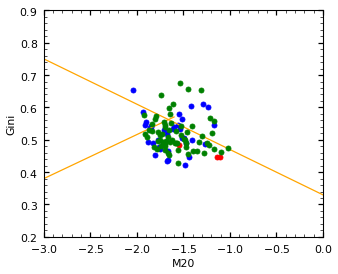

In [168]:
plt.scatter(meas_cat['M20'][mask & candy], meas_cat['Gini'][mask & candy], color='g', zorder=10)
plt.scatter(meas_cat['M20'][mask & junk], meas_cat['Gini'][mask & junk], color='r')
plt.scatter(meas_cat['M20'][mask & gal], meas_cat['Gini'][mask & gal], color='b')

plt.xlabel('M20')
plt.ylabel('Gini')

plt.xlim(-3, 0)
plt.ylim(0.2, 0.9)

x = np.linspace(-3, 0, 10)
plt.plot(x, -0.14 * x + 0.33, color='orange')
x = np.linspace(-3, -1.6, 10)
plt.plot(x, 0.136 * x + 0.788, color='orange')

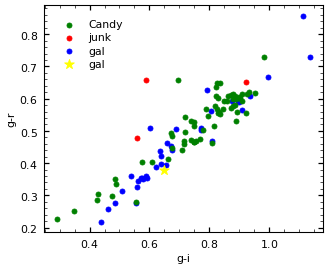

In [169]:
plt.scatter((g_mag - i_mag)[candy & mask], (g_mag - r_mag)[candy & mask], color='g', zorder=10, label='Candy')
plt.scatter((g_mag - i_mag)[junk & mask], (g_mag - r_mag)[junk & mask], color='r', label='junk')
plt.scatter((g_mag - i_mag)[gal & mask], (g_mag - r_mag)[gal & mask], color='b', label='gal')

plt.scatter((g_mag - i_mag)[327], (g_mag - r_mag)[327], color='yellow', marker='*', s=150, label='gal', zorder=10)

plt.xlabel('g-i')
plt.ylabel('g-r')

plt.legend()

#plt.xlim(-0.5, 2.2)
#plt.ylim(-0.5, 2.2)

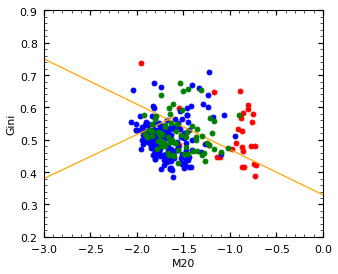

In [63]:
plt.scatter(meas_cat['M20'][candy & mask], meas_cat['Gini'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['M20'][junk & mask], meas_cat['Gini'][junk & mask], color='r')
plt.scatter(meas_cat['M20'][gal & mask], meas_cat['Gini'][gal & mask], color='b')

plt.xlabel('M20')
plt.ylabel('Gini')

plt.xlim(-3, 0)
plt.ylim(0.2, 0.9)

x = np.linspace(-3, 0, 10)
plt.plot(x, -0.14 * x + 0.33, color='orange')
x = np.linspace(-3, -1.6, 10)
plt.plot(x, 0.136 * x + 0.788, color='orange')

Text(0, 0.5, 'r50')

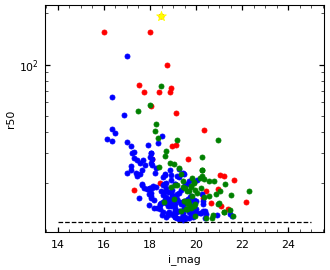

In [64]:
plt.scatter(i_mag[candy & mask], meas_cat['rhalf_ellip'][candy & mask], color='g', zorder=10)
plt.scatter(i_mag[junk & mask], meas_cat['rhalf_ellip'][junk & mask], color='r')
plt.scatter(i_mag[gal & mask], meas_cat['rhalf_ellip'][gal & mask], color='b')
plt.scatter(i_mag[327], meas_cat['rhalf_ellip'][327], color='yellow', marker='*', s=150, label='gal', zorder=10)


#plt.ylim(0, 1)
plt.hlines(2 / 0.168, 14, 25, color='k', ls='--')
plt.yscale('log')
plt.xlabel('i_mag')
plt.ylabel('r50')

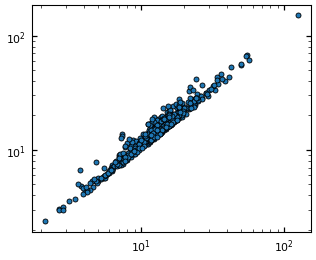

In [30]:
plt.scatter(meas_cat['r50'], meas_cat['sersic_rhalf'])
plt.xscale('log')
plt.yscale('log')

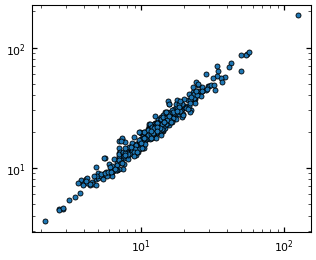

In [31]:
plt.scatter(meas_cat['r50'], meas_cat['r80'])
plt.xscale('log')
plt.yscale('log')

In [32]:
print('Candy:', np.sum(candy))
print('Gal:', np.sum(gal))
print('Junk:', np.sum(junk))

Candy: 178
Gal: 167
Junk: 156


Text(0, 0.5, 'r50')

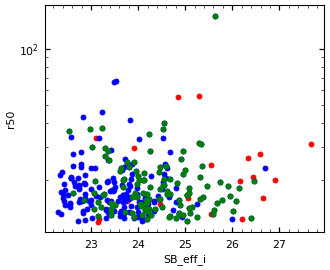

In [106]:
plt.scatter(meas_cat['SB_eff_circ'][:, 2][candy & mask], meas_cat['rhalf_ellip'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['SB_eff_circ'][:, 2][junk & mask], meas_cat['rhalf_ellip'][junk & mask], color='r')
plt.scatter(meas_cat['SB_eff_circ'][:, 2][~junk & mask], meas_cat['rhalf_ellip'][~junk & mask], color='b')

#plt.ylim(0, 1)
plt.yscale('log')
plt.xlabel('SB_eff_i')
plt.ylabel('r50')

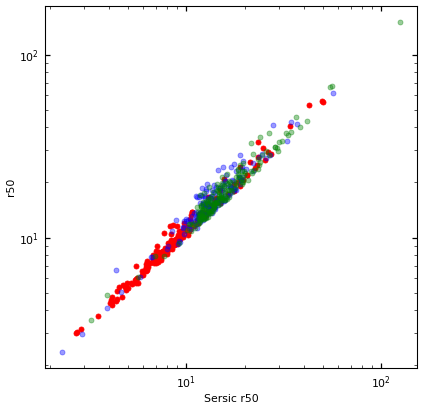

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.scatter(meas_cat['rhalf_circ'][candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10, alpha=.4)
plt.scatter(meas_cat['rhalf_circ'][junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter(meas_cat['rhalf_circ'][gal], meas_cat['rhalf_ellip'][gal], color='b', alpha=0.4)

# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(-5, 100)
#plt.ylim(-5, 100)

plt.xlabel('Sersic r50')
plt.ylabel('r50')
plt.xscale('log')
plt.yscale('log')

Text(0, 0.5, 'r50 / r20')

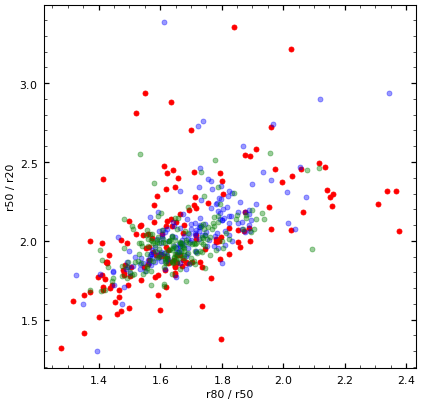

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.scatter(meas_cat['r80'][candy] / meas_cat['r50'][candy], 
            meas_cat['r50'][candy] / meas_cat['r20'][candy], color='g', zorder=10, alpha=.4)

plt.scatter(meas_cat['r80'][junk] / meas_cat['r50'][junk], 
            meas_cat['r50'][junk] / meas_cat['r20'][junk], color='r')

plt.scatter(meas_cat['r80'][gal] / meas_cat['r50'][gal], 
            meas_cat['r50'][gal] / meas_cat['r20'][gal], color='b', alpha=0.4)

# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(-5, 100)
#plt.ylim(-5, 100)

plt.xlabel('r80 / r50')
plt.ylabel('r50 / r20')

In [79]:
lsbg_cat[mask].write('./Catalog/nsa_20hosts_sample_211103_visual_inspect.fits', overwrite=True)

In [110]:
1.5 / (50 * 1000) * 206265

6.18795